<a href="https://colab.research.google.com/github/DiploDatos/AnalisisYCuracion/blob/master/Entregable_Parte_2_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Exploración y Curación de Datos**

*Edición 2021*

----

# Trabajo práctico entregable - parte 2


En el ejercicio 2 de la parte 1 del entregable seleccionaron las filas y columnas relevantes al problema de predicción de precios de una propiedad e imputaron los valores faltantes de las columnas `Suburb` y las columnas obtenidas a partir del conjunto de datos `airbnb`.

En esta notebook, **se utilizará resultado de dichas operaciones.** que fue guardado en un archivo (Ejercicio 3 entregable 1). 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

from sklearn.experimental import enable_iterative_imputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge # para comparar el estimador de Iterative_Imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

import seaborn as sns

sns.set_context('talk')

In [2]:
# Acá deberían leer el conjunto de datos que ya tienen.
melb_df = pd.read_csv('melb_df_merged_Alfredo.csv')
melb_df[:3]

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,avg_dayly_price,avg_weekly_price,avg_montly_price
0,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,130.624031,605.152174,2187.032258
1,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,130.624031,605.152174,2187.032258
2,Abbotsford,3,h,1465000.0,SP,2.5,3067.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,130.624031,605.152174,2187.032258


In [3]:
melb_df.shape

(13190, 19)

## Ejercicio 1: Encoding

1. Seleccionar todas las filas y columnas del conjunto de datos obtenido en la parte 1 del entregable, **excepto** `BuildingArea` y `YearBuilt`, que volveremos a imputar más adelante.

2. Aplicar una codificación One-hot encoding a cada fila, tanto para variables numéricas como categóricas. Si lo consideran necesario, pueden volver a reducir el número de categorías únicas.

Algunas opciones:
  1. Utilizar `OneHotEncoder` junto con el parámetro `categories` para las variables categóricas y luego usar `numpy.hstack` para concatenar el resultado con las variables numéricas. 
  2. `DictVectorizer` con algunos pasos de pre-proceso previo.

Recordar también que el atributo `pandas.DataFrame.values` permite acceder a la matriz de numpy subyacente a un DataFrame.


In [4]:
melb_df.columns

Index(['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'Distance', 'Postcode',
       'Bathroom', 'Car', 'Landsize', 'BuildingArea', 'YearBuilt',
       'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname',
       'avg_dayly_price', 'avg_weekly_price', 'avg_montly_price'],
      dtype='object')

Quitamos algunas columnas que no nos aportan valor, como "Lattitude" y "Longitude".

In [5]:
melb_aux = melb_df.copy()
filter_columns = ['Suburb', 'Rooms', 'Type', 'Price', 'Method', 'Distance', 'Postcode',
       'Bathroom', 'Car', 'BuildingArea', 'YearBuilt', 'CouncilArea',
       'Regionname', 'avg_dayly_price', 'avg_weekly_price', 'avg_montly_price']
melb_aux = melb_aux[filter_columns]
melb_aux.head()

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bathroom,Car,BuildingArea,YearBuilt,CouncilArea,Regionname,avg_dayly_price,avg_weekly_price,avg_montly_price
0,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
1,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,79.0,1900.0,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
2,Abbotsford,3,h,1465000.0,SP,2.5,3067.0,2.0,0.0,150.0,1900.0,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
3,Abbotsford,3,h,850000.0,PI,2.5,3067.0,2.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
4,Abbotsford,4,h,1600000.0,VB,2.5,3067.0,1.0,2.0,142.0,2014.0,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258


In [6]:
melb_aux.shape

(13190, 16)

In [7]:
melb_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13190 entries, 0 to 13189
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Suburb            13190 non-null  object 
 1   Rooms             13190 non-null  int64  
 2   Type              13190 non-null  object 
 3   Price             13190 non-null  float64
 4   Method            13190 non-null  object 
 5   Distance          13190 non-null  float64
 6   Postcode          13190 non-null  float64
 7   Bathroom          13190 non-null  float64
 8   Car               13142 non-null  float64
 9   BuildingArea      6795 non-null   float64
 10  YearBuilt         7827 non-null   float64
 11  CouncilArea       11863 non-null  object 
 12  Regionname        13190 non-null  object 
 13  avg_dayly_price   13190 non-null  float64
 14  avg_weekly_price  12335 non-null  float64
 15  avg_montly_price  11942 non-null  float64
dtypes: float64(10), int64(1), object(5)
memo

In [8]:
melb_aux.isna().sum()

Suburb                 0
Rooms                  0
Type                   0
Price                  0
Method                 0
Distance               0
Postcode               0
Bathroom               0
Car                   48
BuildingArea        6395
YearBuilt           5363
CouncilArea         1327
Regionname             0
avg_dayly_price        0
avg_weekly_price     855
avg_montly_price    1248
dtype: int64

Como son pocos valores nulos en la columna "Car", los llenamos con 0 suponiendo que no lo completaron porque realmente no tiene cochera ese lugar. ***Es decir que se asume que el valor NO EXISTE***. Existe una buena cantidad (919) de datos en donde se ha informado 0 como valor de "Car", por lo que se considera apropiado asumir que los valores faltantes (48) son derivados de "no responder" en lugar de colocar "0".

In [9]:
# Contar las respuestas con Car = 0
melb_aux['Car'][melb_aux['Car'] == 0 ].count()

919

In [10]:
# Se hace la imputación simple asignando 0 a los valores de 'Car' faltantes 
melb_aux['Car'] = melb_aux['Car'].fillna(0)

In [11]:
melb_aux.head()

,Suburb,Rooms,Type,Price,Method,Distance,Postcode,Bathroom,Car,BuildingArea,YearBuilt,CouncilArea,Regionname,avg_dayly_price,avg_weekly_price,avg_montly_price
0,Abbotsford,2,h,1480000.0,S,2.5,3067.0,1.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
1,Abbotsford,2,h,1035000.0,S,2.5,3067.0,1.0,0.0,79.0,1900.0,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
2,Abbotsford,3,h,1465000.0,SP,2.5,3067.0,2.0,0.0,150.0,1900.0,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
3,Abbotsford,3,h,850000.0,PI,2.5,3067.0,2.0,1.0,NaN,NaN,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258
4,Abbotsford,4,h,1600000.0,VB,2.5,3067.0,1.0,2.0,142.0,2014.0,Yarra,Northern Metropolitan,130.624031,605.152174,2187.032258


In [12]:
melb_aux.isna().sum()

Suburb                 0
Rooms                  0
Type                   0
Price                  0
Method                 0
Distance               0
Postcode               0
Bathroom               0
Car                    0
BuildingArea        6395
YearBuilt           5363
CouncilArea         1327
Regionname             0
avg_dayly_price        0
avg_weekly_price     855
avg_montly_price    1248
dtype: int64

De las columnas categóricas que nos quedan, veremos cuantos valores distintos tiene cada una para ver si **conviene hacer alguna reducción de categorías únicas**.

In [15]:
# Contamos valores distintos en columnas categóricas. Muchos valores distintos producirían alta dimensionalidad en el encoding.
for a in melb_aux.select_dtypes(include='object').columns:
    print('En la columna {} hay {} valores distintos.'.format(a, melb_aux[a].nunique()))

En la columna Suburb hay 306 valores distintos.
En la columna Type hay 3 valores distintos.
En la columna Method hay 5 valores distintos.
En la columna CouncilArea hay 31 valores distintos.
En la columna Regionname hay 8 valores distintos.


/home/fredy/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


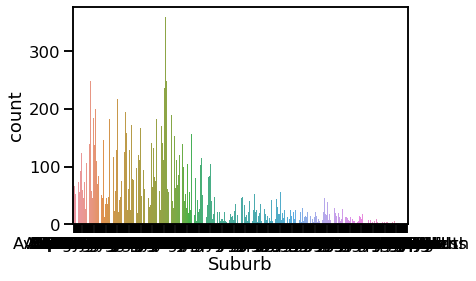

In [16]:
fig = sns.countplot(melb_aux.Suburb)

/home/fredy/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


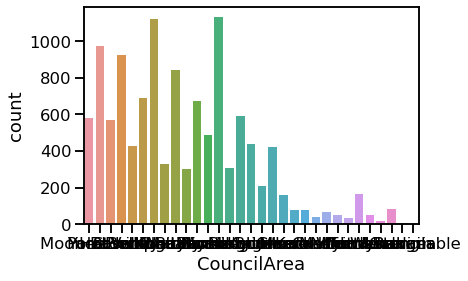

In [17]:
fig = sns.countplot(melb_aux.CouncilArea)

Vamos a **reducir las categorías en las columnas 'Suburb' y 'CouncilArea'**, dejando las que tienen una frecuencia mínima de 120 en el caso de la primera y 120 en el caso de la segunda. Las categorías debajo de esos mínimos se agruparon bajo "Other".

In [18]:
#Creamos categoría otros para categorías con frecuencias menores a 120 en la columna Suburb
OtherCat = melb_aux.Suburb.value_counts() [melb_aux.Suburb.value_counts() < 120]
melb_aux['Suburb'] = np.where(melb_aux['Suburb'].isin(OtherCat.index.to_list()), 'Other', melb_aux['Suburb'])

In [19]:
for a in melb_aux.select_dtypes(include='object').columns:
    print('En la columna {} hay {} valores distintos.'.format(a, melb_aux[a].nunique()))

En la columna Suburb hay 33 valores distintos.
En la columna Type hay 3 valores distintos.
En la columna Method hay 5 valores distintos.
En la columna CouncilArea hay 31 valores distintos.
En la columna Regionname hay 8 valores distintos.


In [24]:
#Creamos categoría otros para categorías con frecuencias menores a 250 en la columna ConcilArea
OtherCat = melb_aux.CouncilArea.value_counts() [melb_aux.CouncilArea.value_counts() < 250]
melb_aux['CouncilArea'] = np.where(melb_aux['CouncilArea'].isin(OtherCat.index.to_list()), 'Other', melb_aux['CouncilArea'])

In [25]:
for a in melb_aux.select_dtypes(include='object').columns:
    print('En la columna {} hay {} valores distintos.'.format(a, melb_aux[a].nunique()))

En la columna Suburb hay 33 valores distintos.
En la columna Type hay 3 valores distintos.
En la columna Method hay 5 valores distintos.
En la columna CouncilArea hay 18 valores distintos.
En la columna Regionname hay 8 valores distintos.


Ademas de las columnas categóricas especificadas como "Object", incluyo las columnas Rooms, Bathroom y Car ya que considero que por más que sean numéricas, corresponden a variables categóricas cada una de ellas.

***Comentario Alfredo:*** En este punto es necesario decidir si las columnas Rooms, Bathroom y Car las consideramos como necesarias a ser sometidas a encoding. Estrictamente hablando, las tres variables contienen valores numéricos, con lo cual los algoritmos de ML no fallarían al procesarlas. Una aproximación sería ir por el camino que siguió Diego, considerándolas "Categóricas", y la otra es considerarlas variables numéricas "Discretas", es decir que son valores basados en conteos de un set de posibilidades que solo pueden tomar valores enteros. En esta últimas aproximación, si dejamos las 3 columnas tal como están, podríamos pensar que provienen de un encoding del tipo ordinal. Al respecto de este encoding, me aclaró ver [este](https://www.kaggle.com/code/alexisbcook/categorical-variables) notebook en Kaggle

Entonces, a lo que hizo Diego, le podemos sumar un segundo dataframe sin el OneHotEncoding sobre Rooms, Bathroom y Car. Los mantenemos como dos opciones, y cuando vayamos a los métodos de ML ya podremos cuantificar con alguna métrica cual de los dos dataframes originan modelos con mayor performance. En este sentido me sirvió [este](https://www.kaggle.com/code/shahules/an-overview-of-encoding-techniques) notebook en Kaggle en donde se comparan las performances de distintas aproximaciones de encodings.  




In [26]:
categorical_cols_aprox1 = ['Suburb', 'Type', 'Method', 'CouncilArea', 'Regionname', 'Rooms', 'Bathroom', 'Car']
categorical_cols_aprox2 = ['Suburb', 'Type', 'Method', 'CouncilArea', 'Regionname']


In [27]:
numeric_cols_aprox1 = melb_aux.columns[~melb_aux.columns.isin(categorical_cols_aprox1)].tolist()
numeric_cols_aprox2 = melb_aux.columns[~melb_aux.columns.isin(categorical_cols_aprox2)].tolist()

In [28]:
numeric_cols_aprox1

['Price',
 'Distance',
 'Postcode',
 'BuildingArea',
 'YearBuilt',
 'avg_dayly_price',
 'avg_weekly_price',
 'avg_montly_price']

In [29]:
numeric_cols_aprox2

['Rooms',
 'Price',
 'Distance',
 'Postcode',
 'Bathroom',
 'Car',
 'BuildingArea',
 'YearBuilt',
 'avg_dayly_price',
 'avg_weekly_price',
 'avg_montly_price']

In [31]:
# Hacemos las codificación OneHotEncoder para la opción 1 de columnas categóricas
onehot_aprox1 = make_column_transformer(
    (OneHotEncoder(sparse=False), categorical_cols_aprox1),
    remainder='passthrough')

melb_cat_aprox1 = onehot_aprox1.fit_transform(melb_aux)
melb_cat_df_aprox1 = pd.DataFrame(melb_cat_aprox1, columns=onehot_aprox1.get_feature_names_out())
melb_cat_df_aprox1.head()

,onehotencoder__Suburb_Ascot Vale,onehotencoder__Suburb_Balwyn North,onehotencoder__Suburb_Bentleigh,onehotencoder__Suburb_Bentleigh East,onehotencoder__Suburb_Brighton,onehotencoder__Suburb_Brighton East,onehotencoder__Suburb_Brunswick,onehotencoder__Suburb_Camberwell,onehotencoder__Suburb_Carnegie,onehotencoder__Suburb_Coburg,...,onehotencoder__Car_9.0,onehotencoder__Car_10.0,remainder__Price,remainder__Distance,remainder__Postcode,remainder__BuildingArea,remainder__YearBuilt,remainder__avg_dayly_price,remainder__avg_weekly_price,remainder__avg_montly_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1480000.0,2.5,3067.0,NaN,NaN,130.624031,605.152174,2187.032258
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1035000.0,2.5,3067.0,79.0,1900.0,130.624031,605.152174,2187.032258
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1465000.0,2.5,3067.0,150.0,1900.0,130.624031,605.152174,2187.032258
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,850000.0,2.5,3067.0,NaN,NaN,130.624031,605.152174,2187.032258
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1600000.0,2.5,3067.0,142.0,2014.0,130.624031,605.152174,2187.032258


In [32]:
# Hacemos las codificación OneHotEncoder para la opción 2 de columnas categóricas
onehot_aprox2 = make_column_transformer(
    (OneHotEncoder(sparse=False), categorical_cols_aprox2),
    remainder='passthrough')

melb_cat_aprox2 = onehot_aprox2.fit_transform(melb_aux)
melb_cat_df_aprox2 = pd.DataFrame(melb_cat_aprox2, columns=onehot_aprox2.get_feature_names_out())
melb_cat_df_aprox2.head()

,onehotencoder__Suburb_Ascot Vale,onehotencoder__Suburb_Balwyn North,onehotencoder__Suburb_Bentleigh,onehotencoder__Suburb_Bentleigh East,onehotencoder__Suburb_Brighton,onehotencoder__Suburb_Brighton East,onehotencoder__Suburb_Brunswick,onehotencoder__Suburb_Camberwell,onehotencoder__Suburb_Carnegie,onehotencoder__Suburb_Coburg,...,remainder__Price,remainder__Distance,remainder__Postcode,remainder__Bathroom,remainder__Car,remainder__BuildingArea,remainder__YearBuilt,remainder__avg_dayly_price,remainder__avg_weekly_price,remainder__avg_montly_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1480000.0,2.5,3067.0,1.0,1.0,NaN,NaN,130.624031,605.152174,2187.032258
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1035000.0,2.5,3067.0,1.0,0.0,79.0,1900.0,130.624031,605.152174,2187.032258
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1465000.0,2.5,3067.0,2.0,0.0,150.0,1900.0,130.624031,605.152174,2187.032258
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,850000.0,2.5,3067.0,2.0,1.0,NaN,NaN,130.624031,605.152174,2187.032258
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1600000.0,2.5,3067.0,1.0,2.0,142.0,2014.0,130.624031,605.152174,2187.032258


In [33]:
# Vemos como aumnetó la dimensionalidad producto del encoding
print(f'Dataframe aprox1: rows: {melb_cat_df_aprox1.shape[0]} cols: {melb_cat_df_aprox1.shape[1]}')
print(f'Dataframe aprox2: rows: {melb_cat_df_aprox2.shape[0]} cols: {melb_cat_df_aprox2.shape[1]}')
print(f'Dataframe original: rows: {melb_aux.shape[0]} cols: {melb_aux.shape[1]}')

Dataframe aprox1: rows: 13190 cols: 105
Dataframe aprox2: rows: 13190 cols: 79
Dataframe original: rows: 13190 cols: 16


Se renombran las columnas producto del encoding para eliminar el prefijo 'remainder_'

In [34]:
melb_cat_df_aprox1.columns[melb_cat_df_aprox1.columns.str.contains('remainder')]

Index(['remainder__Price', 'remainder__Distance', 'remainder__Postcode',
       'remainder__BuildingArea', 'remainder__YearBuilt',
       'remainder__avg_dayly_price', 'remainder__avg_weekly_price',
       'remainder__avg_montly_price'],
      dtype='object')

In [35]:
melb_cat_df_aprox1.rename(columns={'remainder__Price': 'Price', 'remainder__Distance': 'Distance', 
       'remainder__airbnb_price_mean': 'Price_mean', 'remainder__Postcode': 'Postcode',
       'remainder__airbnb_price_count': 'Price_count','remainder__YearBuilt': 'YearBuilt',
       'remainder__BuildingArea': 'BuildingArea', 'remainder__avg_weekly_price': 'avg_weekly_price',
        'remainder__avg_montly_price': 'avg_monthly_price'}, inplace=True)

In [43]:
melb_cat_df_aprox1.head()

,onehotencoder__Suburb_Ascot Vale,onehotencoder__Suburb_Balwyn North,onehotencoder__Suburb_Bentleigh,onehotencoder__Suburb_Bentleigh East,onehotencoder__Suburb_Brighton,onehotencoder__Suburb_Brighton East,onehotencoder__Suburb_Brunswick,onehotencoder__Suburb_Camberwell,onehotencoder__Suburb_Carnegie,onehotencoder__Suburb_Coburg,...,onehotencoder__Car_9.0,onehotencoder__Car_10.0,Price,Distance,Postcode,BuildingArea,YearBuilt,remainder__avg_dayly_price,avg_weekly_price,avg_monthly_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1480000.0,2.5,3067.0,NaN,NaN,130.624031,605.152174,2187.032258
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1035000.0,2.5,3067.0,79.0,1900.0,130.624031,605.152174,2187.032258
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1465000.0,2.5,3067.0,150.0,1900.0,130.624031,605.152174,2187.032258
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,850000.0,2.5,3067.0,NaN,NaN,130.624031,605.152174,2187.032258
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1600000.0,2.5,3067.0,142.0,2014.0,130.624031,605.152174,2187.032258


In [39]:
melb_cat_df_aprox2.rename(columns={'remainder__Price': 'Price', 'remainder__Distance': 'Distance', 
       'remainder__airbnb_price_mean': 'Price_mean', 'remainder__Postcode': 'Postcode',
       'remainder__airbnb_price_count': 'Price_count','remainder__YearBuilt': 'YearBuilt',
       'remainder__BuildingArea': 'BuildingArea', 'remainder__avg_weekly_price': 'avg_weekly_price',
        'remainder__avg_montly_price': 'avg_monthly_price'}, inplace=True)

In [42]:
melb_cat_df_aprox2.head()

,onehotencoder__Suburb_Ascot Vale,onehotencoder__Suburb_Balwyn North,onehotencoder__Suburb_Bentleigh,onehotencoder__Suburb_Bentleigh East,onehotencoder__Suburb_Brighton,onehotencoder__Suburb_Brighton East,onehotencoder__Suburb_Brunswick,onehotencoder__Suburb_Camberwell,onehotencoder__Suburb_Carnegie,onehotencoder__Suburb_Coburg,...,Price,Distance,Postcode,remainder__Bathroom,remainder__Car,BuildingArea,YearBuilt,remainder__avg_dayly_price,avg_weekly_price,avg_monthly_price
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1480000.0,2.5,3067.0,1.0,1.0,NaN,NaN,130.624031,605.152174,2187.032258
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1035000.0,2.5,3067.0,1.0,0.0,79.0,1900.0,130.624031,605.152174,2187.032258
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1465000.0,2.5,3067.0,2.0,0.0,150.0,1900.0,130.624031,605.152174,2187.032258
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,850000.0,2.5,3067.0,2.0,1.0,NaN,NaN,130.624031,605.152174,2187.032258
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1600000.0,2.5,3067.0,1.0,2.0,142.0,2014.0,130.624031,605.152174,2187.032258


## Ejercicio 2: Imputación por KNN

En el teórico se presentó el método `IterativeImputer` para imputar valores faltantes en variables numéricas. Sin embargo, los ejemplos presentados sólo utilizaban algunas variables numéricas presentes en el conjunto de datos. En este ejercicio, utilizaremos la matriz de datos codificada para imputar datos faltantes de manera más precisa.

1. Agregue a la matriz obtenida en el punto anterior las columnas `YearBuilt` y `BuildingArea`.
2. Aplique una instancia de `IterativeImputer` con un estimador `KNeighborsRegressor` para imputar los valores de las variables. ¿Es necesario estandarizar o escalar los datos previamente?
3. Realice un gráfico mostrando la distribución de cada variable antes de ser imputada, y con ambos métodos de imputación.

**El ejercicio de imputación de valores faltantes de realiza sobre el 'melb_cat_df_aprox1' que es el que tiene la mayor dimensionalidad y por lo tanto es las estrategia de performance mas conservadora. En etapas posteriores, se pueden repetir estos pasos para el 'melb_cat_df_aprox2' y evaluar la performance de imputación.**

In [47]:
# Se verifica que columnas tienen valores faltantes
melb_cat_df_aprox1.isna().sum().sort_values(ascending=False).head(10)

BuildingArea                                       6395
YearBuilt                                          5363
avg_monthly_price                                  1248
avg_weekly_price                                    855
onehotencoder__Regionname_Southern Metropolitan       0
onehotencoder__Rooms_8                                0
onehotencoder__Rooms_7                                0
onehotencoder__Rooms_6                                0
onehotencoder__Rooms_5                                0
onehotencoder__Rooms_4                                0
dtype: int64

In [48]:
# Se corrige el datatype de la vatiable 'YearBuilt'
melb_cat_df_aprox1['YearBuilt'] = melb_cat_df_aprox1['YearBuilt'].astype('Int64')

In [49]:
# Se detectan la columnas con datos faltantes a imputar
cols_to_impute = melb_cat_df_aprox1.columns[melb_cat_df_aprox1.isna().sum() > 0].tolist()
cols_to_impute

['BuildingArea', 'YearBuilt', 'avg_weekly_price', 'avg_monthly_price']

El método IterativeImputer implementado en scikitlearn asume que la variable que se va a imputar tiene una distribución gaussiana. Entonces para evaluar si es que es necesario realizar algún tipo de tranformación **es necesario visualizar esas distribuciones primero**.

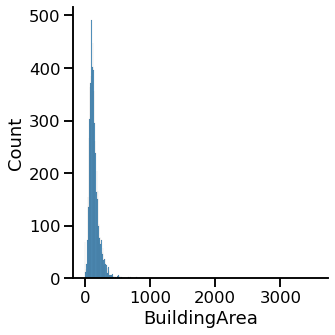

In [51]:
# Vemos la distribución de la variable 'BuildingArea'
sns.displot(melb_cat_df_aprox1.BuildingArea)

La distribución de *'BuildingArea'* es gaussiana, con lo cual no se considera necesario estandarizar esta variable.

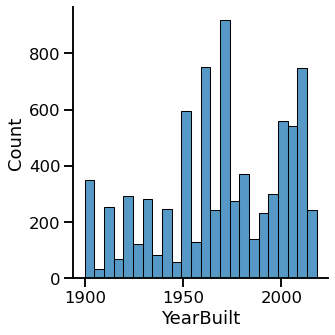

In [52]:
# Vemos la distribución de la variable 'YearBuilt'
sns.displot(melb_cat_df_aprox1.YearBuilt)

La distribución de *'YearBuilt'* tiene un aspecto de distribución del tipo random/gaussiana.

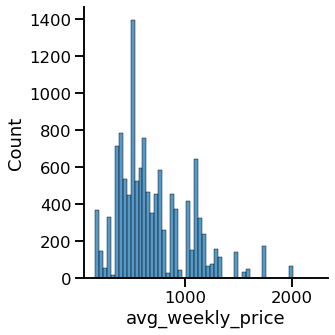

In [53]:
sns.displot(melb_cat_df_aprox1.avg_weekly_price)

La distribución de *'avg_weekly_price'* es gaussiana, con lo cual no se considera necesario estandarizar esta variable.

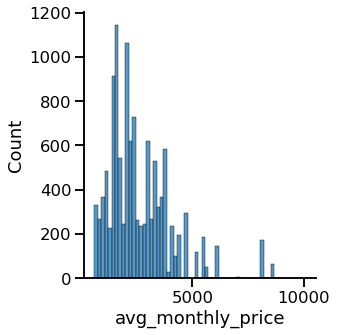

In [54]:
sns.displot(melb_cat_df_aprox1.avg_monthly_price)

La distribución de *'avg_monthly_price'* es gaussiana con cola hacia la derecha, con lo cual no se considera necesario estandarizar esta variable.

In [55]:
# Acá se imputa usando el estimator=KNeighborsRegressor()
df_to_impute_KNNest = melb_cat_df_aprox1.copy(deep=True)
imputer = IterativeImputer(random_state=0, estimator=KNeighborsRegressor(), max_iter=30)
df_to_impute_KNNest[cols_to_impute] = imputer.fit_transform(
    df_to_impute_KNNest[cols_to_impute])

/home/fredy/anaconda3/envs/rdkit-env/lib/python3.10/site-packages/sklearn/impute/_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [56]:
# Acá se imputa usando el estimator=BayesianRidge() que usamos en clase
df_to_impute_BYest = melb_cat_df_aprox1.copy(deep=True)
imputer = IterativeImputer(random_state=0, estimator=BayesianRidge(), max_iter=30)
df_to_impute_BYest[cols_to_impute] = imputer.fit_transform(
    df_to_impute_BYest[cols_to_impute])


In [57]:
df_to_impute_KNNest['YearBuilt'] = df_to_impute_KNNest['YearBuilt'].round().astype('Int64')
df_to_impute_BYest['YearBuilt'] = df_to_impute_BYest['YearBuilt'].round().astype('Int64')

Ejemplo de gráfico comparando las distribuciones de datos obtenidas con cada estimados en la. **Se observa que para ambas variables, el estimador basado en BayesianRidge() resulta en datos mas densamente agrupados sobre un valor, con un impacto mas notable en la imputación sobre YearBuilt**. Para las variables imputadas 'avg_weekly_price'y 'avg_monthly_price', las diferencias entre las distribuciones de ambos estimadores y la original es baja, lo cual demuestra que dicha similitud en la densidad de datos es dependiente de la cantidad de datos faltantes.

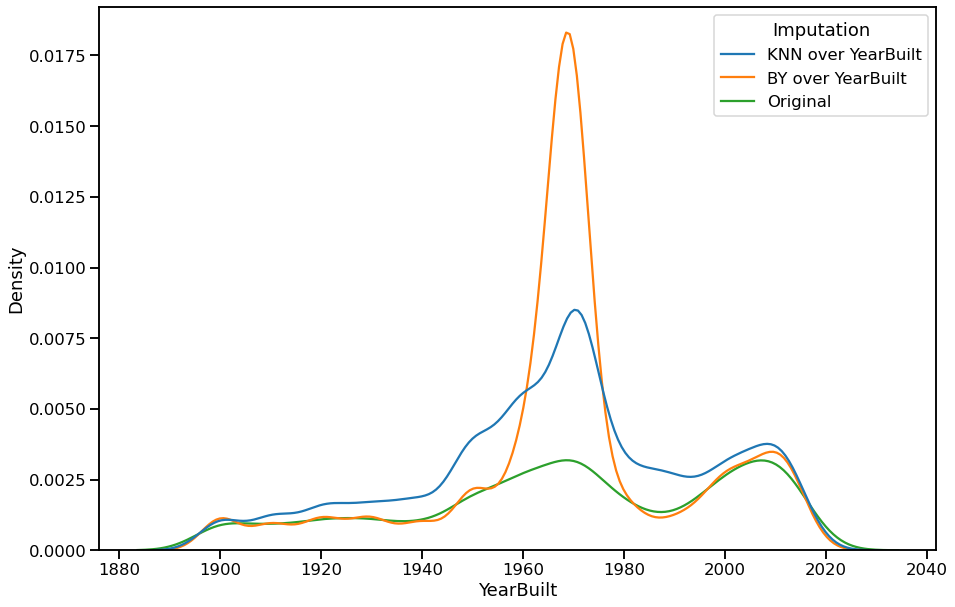

In [58]:
# Acá se grafica la distribución de YearBuilt en Original y ambos estimadores en la imputación
mice_year_built_KNNest = df_to_impute_KNNest.YearBuilt.to_frame()
mice_year_built_KNNest['Imputation'] = 'KNN over YearBuilt'
mice_year_built_BYest = df_to_impute_BYest.YearBuilt.to_frame()
mice_year_built_BYest['Imputation'] = 'BY over YearBuilt'
melb_year_build = melb_cat_df_aprox1.YearBuilt.dropna().to_frame()
melb_year_build['Imputation'] = 'Original'
data = pd.concat([mice_year_built_KNNest,mice_year_built_BYest, melb_year_build]).reset_index(drop=True)
fig = plt.figure(figsize=(15, 10))
g = sns.kdeplot(data=data, x='YearBuilt', hue='Imputation')

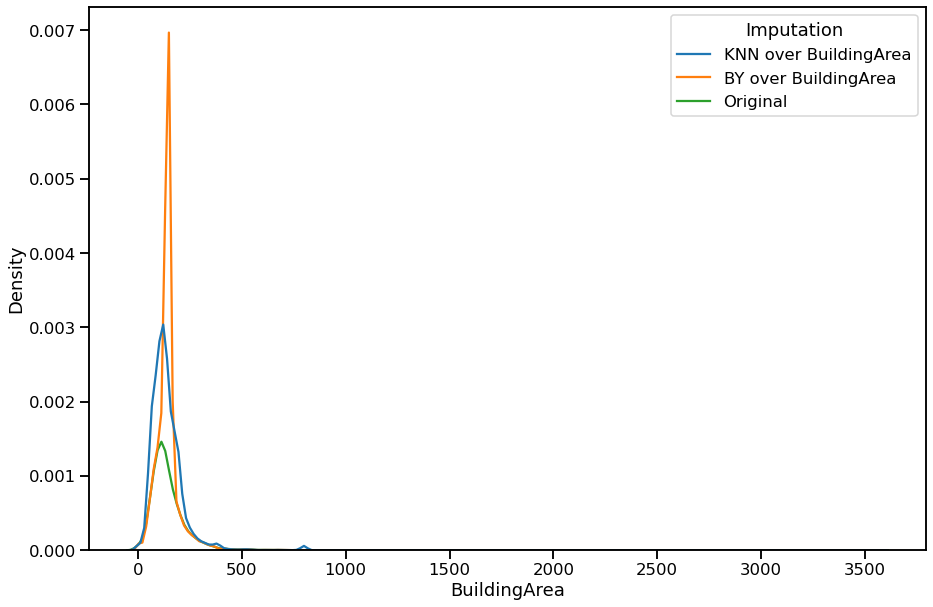

In [59]:
# Acá se grafica la distribución de BuildingArea en Original y ambos estimadores en la imputación
mice_building_area_KNNest = df_to_impute_KNNest.BuildingArea.to_frame()
mice_building_area_KNNest['Imputation'] = 'KNN over BuildingArea'
mice_building_area_BYest = df_to_impute_BYest.BuildingArea.to_frame()
mice_building_area_BYest['Imputation'] = 'BY over BuildingArea'
melb_building_area = melb_cat_df_aprox1.BuildingArea.dropna().to_frame()
melb_building_area['Imputation'] = 'Original'
data = pd.concat([mice_building_area_KNNest,mice_building_area_BYest, melb_building_area]).reset_index(drop=True)
fig = plt.figure(figsize=(15, 10))
g = sns.kdeplot(data=data, x='BuildingArea', hue='Imputation')

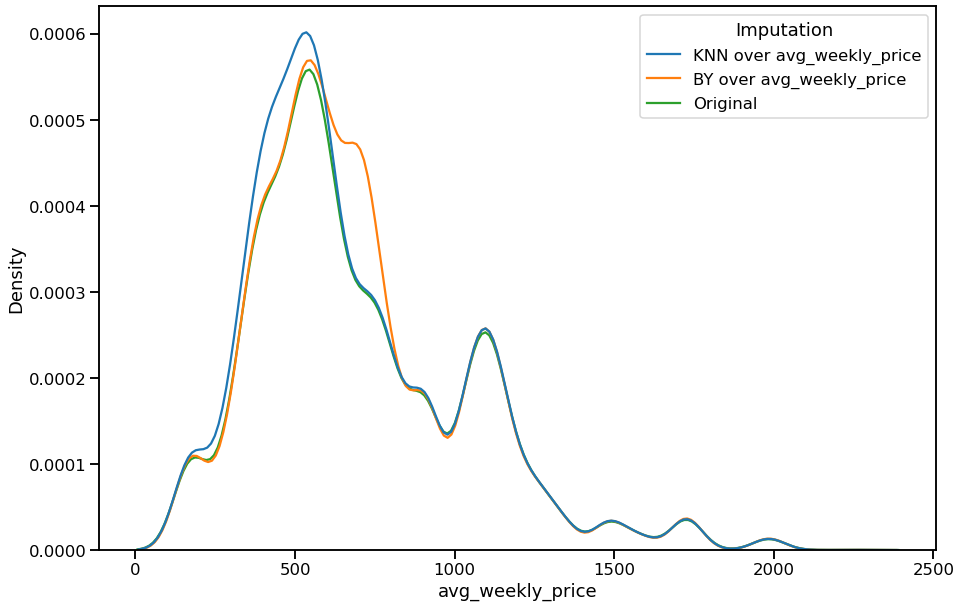

In [60]:
# Acá se grafica la distribución de avg_weekly_price en Original y ambos estimadores en la imputación
mice_avg_weekly_price_KNNest = df_to_impute_KNNest.avg_weekly_price.to_frame()
mice_avg_weekly_price_KNNest['Imputation'] = 'KNN over avg_weekly_price'
mice_avg_weekly_price_BYest = df_to_impute_BYest.avg_weekly_price.to_frame()
mice_avg_weekly_price_BYest['Imputation'] = 'BY over avg_weekly_price'
melb_avg_weekly_price = melb_cat_df_aprox1.avg_weekly_price.dropna().to_frame()
melb_avg_weekly_price['Imputation'] = 'Original'
data = pd.concat([mice_avg_weekly_price_KNNest,mice_avg_weekly_price_BYest, melb_avg_weekly_price]).reset_index(drop=True)
fig = plt.figure(figsize=(15, 10))
g = sns.kdeplot(data=data, x='avg_weekly_price', hue='Imputation')

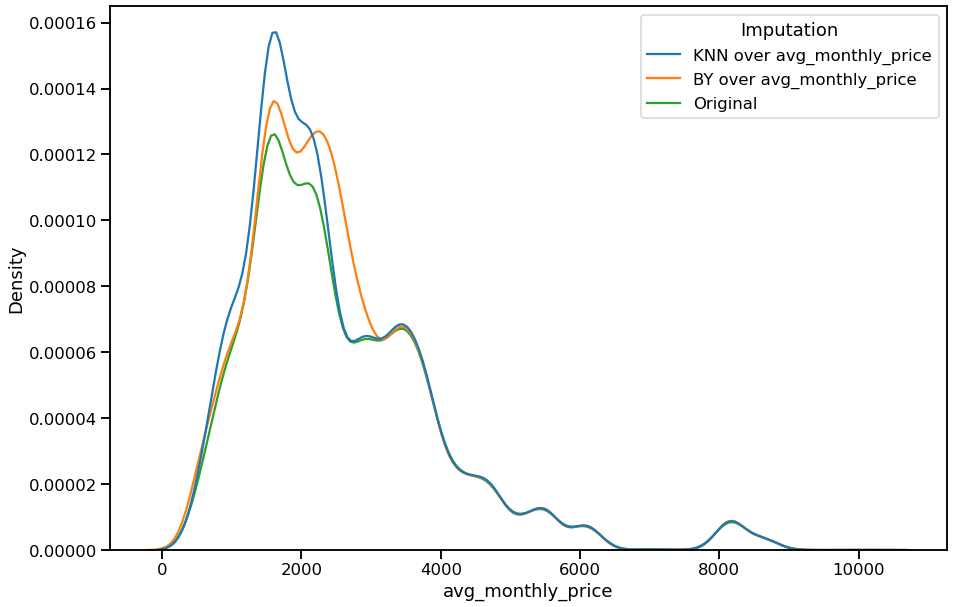

In [61]:
# Acá se grafica la distribución de avg_weekly_price en Original y ambos estimadores en la imputación
mice_avg_monthly_price_KNNest = df_to_impute_KNNest.avg_monthly_price.to_frame()
mice_avg_monthly_price_KNNest['Imputation'] = 'KNN over avg_monthly_price'
mice_avg_monthly_price_BYest = df_to_impute_BYest.avg_monthly_price.to_frame()
mice_avg_monthly_price_BYest['Imputation'] = 'BY over avg_monthly_price'
melb_avg_monthly_price = melb_cat_df_aprox1.avg_monthly_price.dropna().to_frame()
melb_avg_monthly_price['Imputation'] = 'Original'
data = pd.concat([mice_avg_monthly_price_KNNest,mice_avg_monthly_price_BYest, melb_avg_monthly_price]).reset_index(drop=True)
fig = plt.figure(figsize=(15, 10))
g = sns.kdeplot(data=data, x='avg_monthly_price', hue='Imputation')

Se verifica que los dataframes imputados no tengan datos faltantes y mantengan el número de variables del dataframe de origen.

In [62]:
df_to_impute_KNNest.isna().sum().sort_values(ascending=False)

onehotencoder__Suburb_Ascot Vale       0
onehotencoder__CouncilArea_Moreland    0
onehotencoder__Bathroom_0.0            0
onehotencoder__Rooms_10                0
onehotencoder__Rooms_8                 0
                                      ..
onehotencoder__Suburb_Yarraville       0
onehotencoder__Suburb_Thornbury        0
onehotencoder__Suburb_Surrey Hills     0
onehotencoder__Suburb_St Kilda         0
avg_monthly_price                      0
Length: 105, dtype: int64

In [64]:
df_to_impute_KNNest.shape

(13190, 105)

In [65]:
df_to_impute_BYest.isna().sum().sort_values(ascending=False)

onehotencoder__Suburb_Ascot Vale       0
onehotencoder__CouncilArea_Moreland    0
onehotencoder__Bathroom_0.0            0
onehotencoder__Rooms_10                0
onehotencoder__Rooms_8                 0
                                      ..
onehotencoder__Suburb_Yarraville       0
onehotencoder__Suburb_Thornbury        0
onehotencoder__Suburb_Surrey Hills     0
onehotencoder__Suburb_St Kilda         0
avg_monthly_price                      0
Length: 105, dtype: int64

In [66]:
df_to_impute_BYest.shape

(13190, 105)

## Ejercicio 3: Reducción de dimensionalidad.

Utilizando la matriz obtenida en el ejercicio anterior:
1. Aplique `PCA` para obtener $n$ componentes principales de la matriz, donde `n = min(20, X.shape[0])`. ¿Es necesario estandarizar o escalar los datos?
2. Grafique la varianza capturada por los primeros $n$ componentes principales, para cada $n$.
3. En base al gráfico, seleccione las primeras $m$ columnas de la matriz transformada para agregar como nuevas características al conjunto de datos.

**La reducción de dimensionalidad por PCA se hizo sobre *'df_to_impute_KNNest'* que es lo solicitado en el ejercicio. Si mas adelante en el trabajo se demuestra que el estimador BayesianRidge es mejor, es posible volver a esta etapa.***

In [67]:
#Escalamos todas las variables de la matriz (tomamos la matriz que antes habia sido escalada para poder imputar las otras dos columnas)
scaler = MinMaxScaler().fit(df_to_impute_KNNest)
melb_matrix_pca = scaler.fit_transform(df_to_impute_KNNest.values)
melb_matrix_pca

array([[0.        , 0.        , 0.        , ..., 0.12602716, 0.21435899,
        0.1677624 ],
       [0.        , 0.        , 0.        , ..., 0.12602716, 0.21435899,
        0.1677624 ],
       [0.        , 0.        , 0.        , ..., 0.12602716, 0.21435899,
        0.1677624 ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.21012112, 0.21777689,
        0.16065011],
       [0.        , 0.        , 0.        , ..., 0.21012112, 0.21777689,
        0.16065011],
       [0.        , 0.        , 0.        , ..., 0.13296061, 0.3676909 ,
        0.25011532]])

In [68]:
min(20, melb_matrix_pca.shape[0])

20

In [69]:
#Generamos objeto usando el n de la consigna
n = min(20, melb_matrix_pca.shape[1])
pca = PCA(n_components=20)                                  

pca.fit(melb_matrix_pca)

PCA(n_components=20)

In [70]:
print("Principal components")
print(pca.components_)
print("Explained variance: ")
print(pca.explained_variance_)
print("Explained variance ratio")
print(pca.explained_variance_ratio_)

Principal components
[[ 0.00032114 -0.00554323 -0.00188996 ...  0.00867572  0.03627176
   0.03050477]
 [-0.00584408  0.0241352   0.01662425 ...  0.03541472  0.09819086
   0.09058079]
 [ 0.0024218  -0.02613638 -0.02194384 ... -0.02837478 -0.06032555
  -0.05674697]
 ...
 [ 0.01168585 -0.01116753  0.02296367 ... -0.05315073 -0.0633223
  -0.05151359]
 [ 0.01080223 -0.09307076  0.06427196 ... -0.00295943 -0.04784454
  -0.06003091]
 [-0.02892546  0.01207756  0.03028242 ... -0.05048746 -0.20739788
  -0.17495643]]
Explained variance: 
[0.79530409 0.48034184 0.33773957 0.32367323 0.29759926 0.29422887
 0.25869069 0.23797126 0.14428473 0.12695108 0.11860545 0.11689057
 0.10749352 0.09898184 0.09471568 0.09193961 0.08773847 0.08153149
 0.08044208 0.07129375]
Explained variance ratio
[0.14832375 0.08958347 0.06298823 0.06036487 0.05550209 0.05487351
 0.04824566 0.0443815  0.02690902 0.0236763  0.02211985 0.02180002
 0.02004748 0.01846006 0.01766442 0.01714668 0.01636317 0.01520558
 0.0150024  0.01

Text(0.5, 1.0, 'Varianza explicada por componente principal')

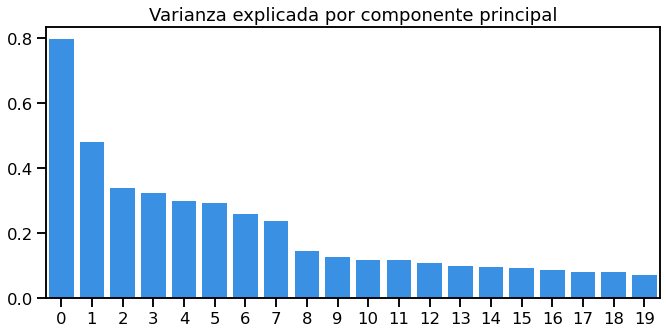

In [71]:
plt.figure(figsize=(11,5))
sns.barplot(x=[i for i in range(20)], y=[pca.explained_variance_[i] for i in range(20)], color='dodgerblue')
plt.title("Varianza explicada por componente principal")

Text(0.5, 1.0, 'Ratios de la Varianza explicada por componente principal')

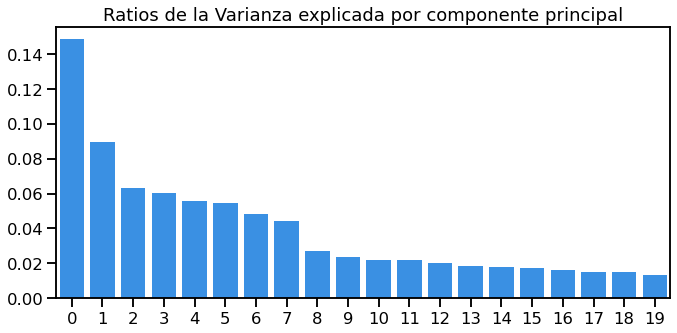

In [72]:
plt.figure(figsize=(11,5))
sns.barplot(x=[i for i in range(20)], y=[pca.explained_variance_ratio_[i] for i in range(20)], color='dodgerblue')
plt.title("Ratios de la Varianza explicada por componente principal")

Text(0.5, 1.0, 'Varianza explicada acumulada por componente principal')

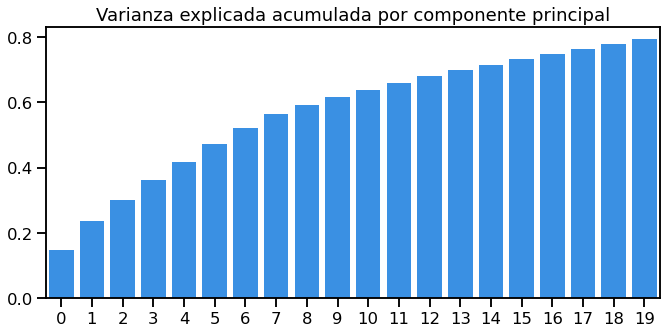

In [73]:
plt.figure(figsize=(11,5))
sns.barplot(x=[i for i in range(20)], y=[sum([pca.explained_variance_ratio_[i] for i in range(x)]) for x in range(1,21)], color='dodgerblue')
plt.title("Varianza explicada acumulada por componente principal")

Del gráfico anterior, podemos ver que si tomamos las primeras 10 columnas, estariamos abarcando el 60% de la totalidad de la varianza en las variables del dataframe original. Por lo tanto extraemos esas primeras 10 columnas y las concatenamos a nuestro anterior dataframe.

Primero creamos el DataFrame con la matrix PCA que obtuvimos al reducir la dimensionalidad.

In [74]:
df_melb_matrix_pca = pd.DataFrame(melb_matrix_pca)

In [75]:
df_melb_matrix_pca.shape

(13190, 105)

Luego lo concatenamos como dijimos anteriormente y generamos un único DataFrame final, que va a contener 115 columnas, resultado de unir las 105 columnas del dataframe original más las 10 que obtuvimos del método PCA.

In [77]:
rango = list(range(0,10,1))
df_final = pd.concat([df_to_impute_KNNest, df_melb_matrix_pca[rango]], axis=1, join='inner')
df_final.shape

(13190, 115)

## Ejercicio 4: Composición del resultado

Transformar nuevamente el conjunto de datos procesado en un `pandas.DataFrame` y guardarlo en un archivo.

Para eso, será necesario recordar el nombre original de cada columna de la matriz, en el orden correcto. Tener en cuenta:
1. El método `OneHotEncoder.get_feature_names` o el atributo `OneHotEncoder.categories_` permiten obtener una lista con los valores de la categoría que le corresponde a cada índice de la matriz.
2. Ninguno de los métodos aplicados intercambia de lugar las columnas o las filas de la matriz.

Por la forma de imputar los datos, ya tenemos armado el dataframe final, por lo que solamente lo guardaremos en un csv.

In [79]:
df_final.shape

(13190, 115)

In [81]:
df_final.to_csv('melbourne_df_final.csv', index=False)

## Ejercicio 5: Documentación

En un documento `.pdf` o `.md` realizar un reporte de las operaciones que realizaron para obtener el conjunto de datos final. Se debe incluir:
  1. Criterios de exclusión (o inclusión) de filas
  2. Interpretación de las columnas presentes
  2. Todas las transofrmaciones realizadas

Este documento es de uso técnico exclusivamente, y su objetivo es permitir que otres desarrolladores puedan reproducir los mismos pasos y obtener el mismo resultado. Debe ser detallado pero consiso. Por ejemplo:

```
  ## Criterios de exclusión de ejemplos
  1. Se eliminan ejemplos donde el año de construcción es previo a 1900

  ## Características seleccionadas
  ### Características categóricas
  1. Type: tipo de propiedad. 3 valores posibles
  2. ...
  Todas las características categóricas fueron codificadas con un
  método OneHotEncoding utilizando como máximo sus 30 valores más 
  frecuentes.
  
  ### Características numéricas
  1. Rooms: Cantidad de habitaciones
  2. Distance: Distancia al centro de la ciudad.
  3. airbnb_mean_price: Se agrega el precio promedio diario de 
     publicaciones de la plataforma AirBnB en el mismo código 
     postal. [Link al repositorio con datos externos].

  ### Transformaciones:
  1. Todas las características numéricas fueron estandarizadas.
  2. La columna `Suburb` fue imputada utilizando el método ...
  3. Las columnas `YearBuilt` y ... fueron imputadas utilizando el 
     algoritmo ...
  4. ...

  ### Datos aumentados
  1. Se agregan las 5 primeras columnas obtenidas a través del
     método de PCA, aplicado sobre el conjunto de datos
     totalmente procesado.
```
